In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-26 17:12:37.987596: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:37.987842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:38.004347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:38.004585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:38.004757: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

#max_epochs = 200
#batch_size_setval = 10000
#learning_rate_setval = 1e-3
#patience_setval = 10

#back = 0.1 #fraction of a background process that we would like to subtract
#background_param = (0, 1.2)  # background
#N = 10**5






##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 
##   About 3 hours.

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6



##-- alt4
##   similar to alt2 but with a much larger batch size.
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

max_epochs = 200
batch_size_setval = 16384
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 3*10**5



In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 1.56 s, sys: 22 ms, total: 1.58 s
Wall time: 1.58 s


In [9]:
theta0_G

array([ 0.52671188, -0.40323982,  0.46640757, ...,  0.74919478,
       -0.24030269,  0.26702383])

In [10]:
theta0_S

array([ 0.48052754, -0.9754784 ,  0.469814  , ...,  0.84969604,
       -0.48124136, -0.21334996])

In [11]:
theta0

array([[ 0.52671188,  0.48052754],
       [-0.40323982, -0.9754784 ],
       [ 0.46640757,  0.469814  ],
       ...,
       [ 0.74919478,  0.84969604],
       [-0.24030269, -0.48124136],
       [ 0.26702383, -0.21334996]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(300000,)

In [14]:
theta0.shape

(300000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(300000,)

/tmp/ipykernel_2909320/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


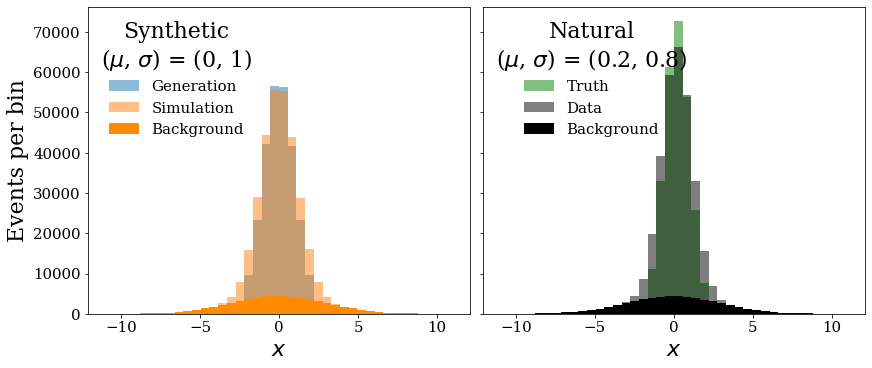

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)


nn_output = np.zeros( shape=(iterations, 2, len(theta0)))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-26 17:12:40.413605: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:40.413813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:40.413986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:40.414146: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 17:12:40.414304: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([ 0.48052754, -0.9754784 ,  0.469814  , ..., -0.29110122,
       -0.99383452, -0.23579377])

In [21]:
xvals_1.shape

(600000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(600000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 24.3 ms, sys: 4.25 ms, total: 28.6 ms
Wall time: 28 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])


training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/100


2023-01-26 17:14:06.336678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-26 17:14:06.339562: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f69cc019a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 17:14:06.339590: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 17:14:06.339597: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 17:14:06.345880: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 17:14:06.450367: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

33/33 [==============================] - 30s 879ms/step - loss: 0.5752 - accuracy: 0.4781 - val_loss: 0.5699 - val_accuracy: 0.4584
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5676 - accuracy: 0.4583 - val_loss: 0.5650 - val_accuracy: 0.4584
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.5646 - accuracy: 0.4583 - val_loss: 0.5635 - val_accuracy: 0.4584
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5636 - accuracy: 0.4583 - val_loss: 0.5629 - val_accuracy: 0.4584
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5631 - accuracy: 0.4583 - val_loss: 0.5624 - val_accuracy: 0.4584
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5626 - accuracy: 0.4584 - val_loss: 0.5621 - val_accuracy: 0.4584
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5623 - accuracy: 0.4598 - val_loss: 0.5617 - val_accuracy: 0.4592
Epoch 8/100
33/33 [===

Epoch 59/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5563 - accuracy: 0.4583 - val_loss: 0.5553 - val_accuracy: 0.4584
Epoch 60/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5562 - accuracy: 0.4583 - val_loss: 0.5553 - val_accuracy: 0.4584
Epoch 61/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5562 - accuracy: 0.4583 - val_loss: 0.5552 - val_accuracy: 0.4584
Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5562 - accuracy: 0.4583 - val_loss: 0.5552 - val_accuracy: 0.4584
Epoch 63/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5561 - accuracy: 0.4583 - val_loss: 0.5552 - val_accuracy: 0.4584
Epoch 64/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5561 - accuracy: 0.4583 - val_loss: 0.5552 - val_accuracy: 0.4584
Epoch 65/100
33/33 [==============================] - 0s 4ms/step - loss: 0.5561 - accuracy: 0.4583 - val_loss: 0.5551 - val_accuracy: 0.4584
Epoch 

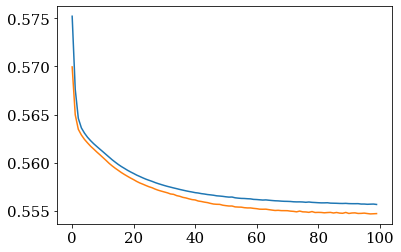

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

34/34 [==============================] - 0s 606us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_2909320/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


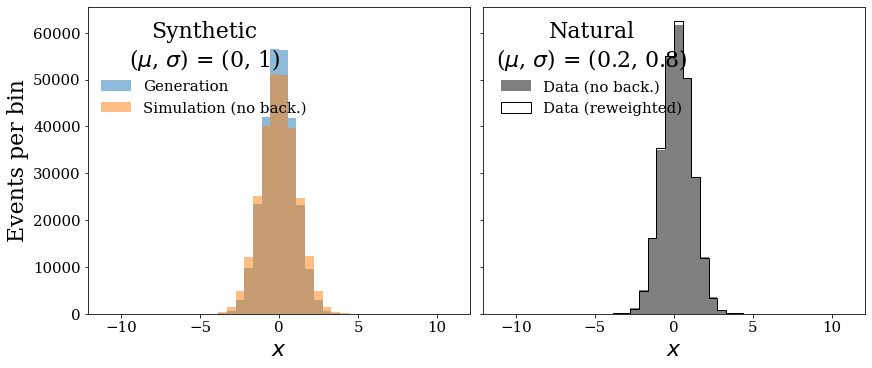

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

34/34 [==============================] - 0s 611us/step


In [32]:
model_output_bgsub

array([[0.40967283],
       [0.48392692],
       [0.48435226],
       ...,
       [0.06335661],
       [0.43461588],
       [0.14654759]], dtype=float32)

In [33]:
model_output_bgsub.shape

(330099, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([0.40967283, 0.48392692, 0.48435226, ..., 0.06335661, 0.43461588,
       0.14654759], dtype=float32)

In [36]:
squeezed_model_output.shape

(330099,)

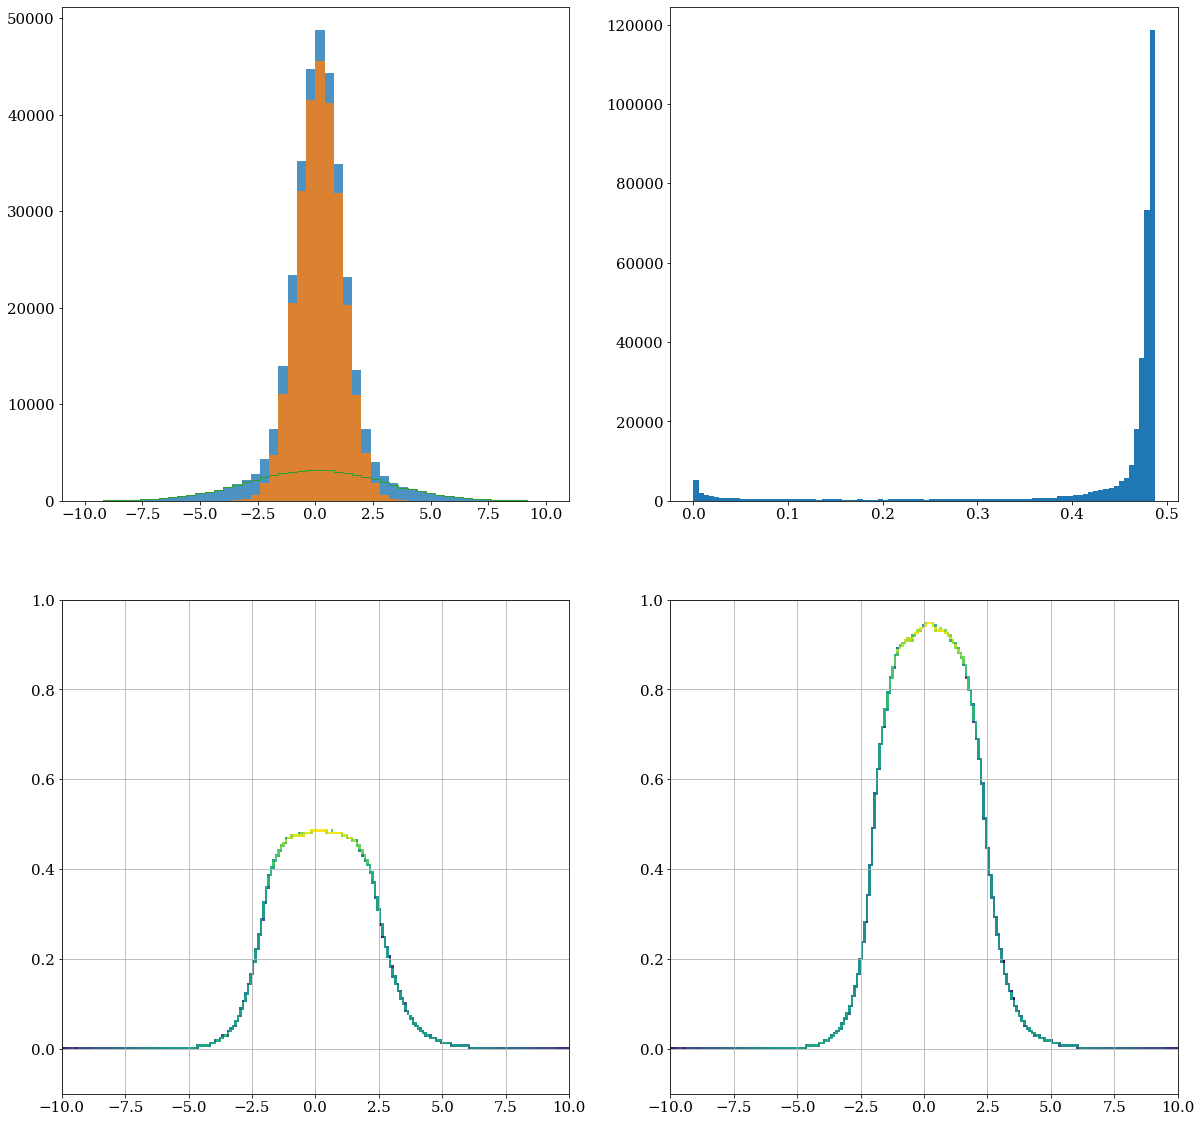

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

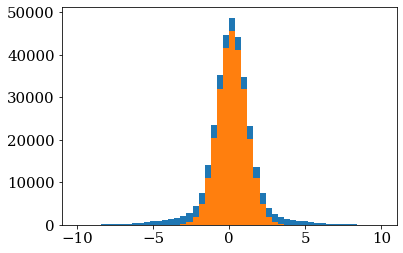

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([1.4000e+01, 2.8000e+01, 3.6000e+01, 5.9000e+01, 7.3000e+01,
        1.0000e+02, 1.4300e+02, 2.2800e+02, 2.8900e+02, 3.9100e+02,
        5.1100e+02, 6.4200e+02, 7.9200e+02, 9.3700e+02, 1.1570e+03,
        1.4670e+03, 1.7090e+03, 2.1330e+03, 2.7420e+03, 4.3730e+03,
        7.4700e+03, 1.3975e+04, 2.3414e+04, 3.5170e+04, 4.4710e+04,
        4.8768e+04, 4.4335e+04, 3.4880e+04, 2.3219e+04, 1.3579e+04,
        7.4560e+03, 4.0600e+03, 2.5780e+03, 1.8070e+03, 1.4020e+03,
        1.1840e+03, 1.0070e+03, 7.9500e+02, 6.0200e+02, 4.7700e+02,
        3.8500e+02, 2.5400e+02, 2.2000e+02, 1.5300e+02, 9.4000e+01,
        8.5000e+01, 5.9000e+01, 4.0000e+01, 2.8000e+01, 1.4000e+01]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6

In [40]:
hist_data_all[0]

array([1.4000e+01, 2.8000e+01, 3.6000e+01, 5.9000e+01, 7.3000e+01,
       1.0000e+02, 1.4300e+02, 2.2800e+02, 2.8900e+02, 3.9100e+02,
       5.1100e+02, 6.4200e+02, 7.9200e+02, 9.3700e+02, 1.1570e+03,
       1.4670e+03, 1.7090e+03, 2.1330e+03, 2.7420e+03, 4.3730e+03,
       7.4700e+03, 1.3975e+04, 2.3414e+04, 3.5170e+04, 4.4710e+04,
       4.8768e+04, 4.4335e+04, 3.4880e+04, 2.3219e+04, 1.3579e+04,
       7.4560e+03, 4.0600e+03, 2.5780e+03, 1.8070e+03, 1.4020e+03,
       1.1840e+03, 1.0070e+03, 7.9500e+02, 6.0200e+02, 4.7700e+02,
       3.8500e+02, 2.5400e+02, 2.2000e+02, 1.5300e+02, 9.4000e+01,
       8.5000e+01, 5.9000e+01, 4.0000e+01, 2.8000e+01, 1.4000e+01])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [45]:
signal_frac

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00613497, 0.0234055 , 0.07126113, 0.21699489, 0.42991082,
       0.64016064, 0.79291592, 0.8744341 , 0.91123116, 0.92914337,
       0.9347728 , 0.92922071, 0.91404817, 0.87415479, 0.80536122,
       0.66966202, 0.44802956, 0.23079907, 0.08356392, 0.0235378 ,
       0.00337838, 0.0019861 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

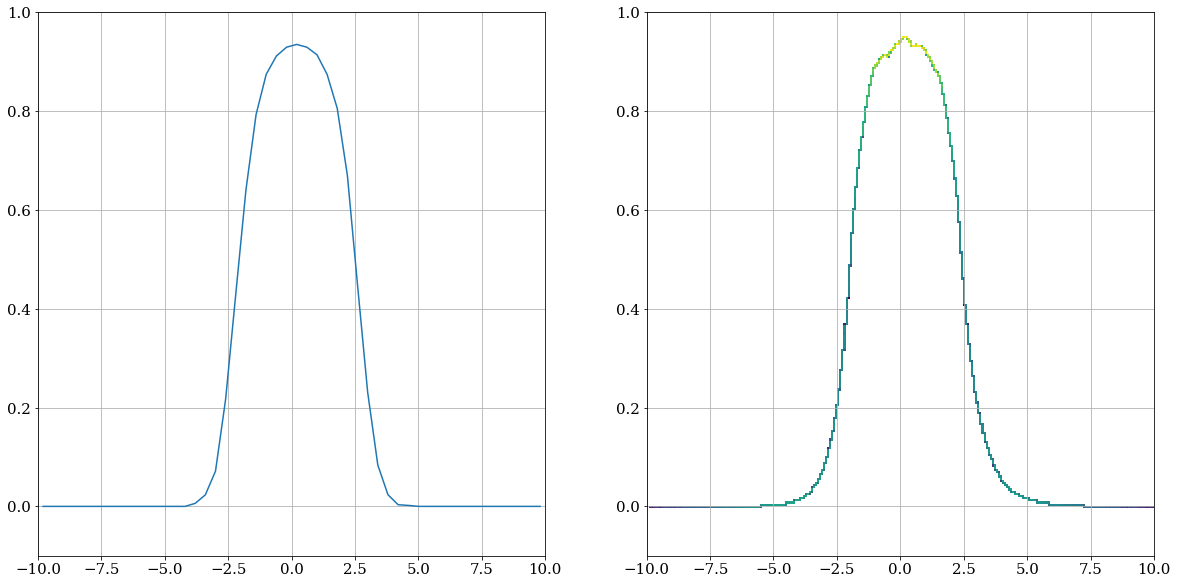

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time

for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    
    
    
    
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 

    ##-- owen: save NN output for each iteration, step.
    nn_output[i,0,:] = np.squeeze(  model.predict(theta0_S, batch_size=10000) )




    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)


        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,0,:] I think.  See Python-syntax-testing notebook.
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    
    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    weights_push = reweight(theta0_G)    
    
    ##-- owen: save NN output for each iteration, step.
    nn_output[i,1,:] = np.squeeze(  model.predict(theta0_G, batch_size=10000) )
    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    

    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    

    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,1,:] I think.  See Python-syntax-testing notebook.
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    
    
    
    




ITERATION: 1




 Iteration 1,  STEP 1, events that pass reco



Epoch 1/200
28/28 [==============================] - 23s 824ms/step - loss: 0.6176 - accuracy: 0.5024 - val_loss: 0.6154 - val_accuracy: 0.5327
Epoch 2/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6151 - accuracy: 0.5303 - val_loss: 0.6151 - val_accuracy: 0.5318
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.5290 - val_loss: 0.6149 - val_accuracy: 0.5310
Epoch 4/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6147 - accuracy: 0.5288 - val_loss: 0.6148 - val_accuracy: 0.5300
Epoch 5/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6146 - accuracy: 0.5283 - val_loss: 0.6147 - val_accuracy: 0.5298
Epoch 6/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6145 - accuracy: 0.5281 - val_loss: 0.6146 - val_accuracy: 0.5298
Epoch 7/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6145 - a

28/28 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.5262 - val_loss: 0.6143 - val_accuracy: 0.5270
Epoch 59/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5259 - val_loss: 0.6143 - val_accuracy: 0.5274
Epoch 60/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5261 - val_loss: 0.6143 - val_accuracy: 0.5272
Epoch 61/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5258 - val_loss: 0.6143 - val_accuracy: 0.5278
Epoch 62/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5262 - val_loss: 0.6143 - val_accuracy: 0.5273
Epoch 63/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5261 - val_loss: 0.6143 - val_accuracy: 0.5274
Epoch 64/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5260 - val_loss: 0.6143 - val_accuracy: 0.5272
Epoch 65/200
28/28 

Epoch 116/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5259 - val_loss: 0.6143 - val_accuracy: 0.5282
Epoch 117/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.5263 - val_loss: 0.6143 - val_accuracy: 0.5277
Epoch 118/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.5263 - val_loss: 0.6143 - val_accuracy: 0.5280
Epoch 119/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5262 - val_loss: 0.6143 - val_accuracy: 0.5276
Epoch 120/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5261 - val_loss: 0.6143 - val_accuracy: 0.5280
Epoch 121/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5265 - val_loss: 0.6143 - val_accuracy: 0.5278
Epoch 122/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5260 - val_loss: 0.6143 - val_accuracy: 0.5281

28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5257 - val_loss: 0.6142 - val_accuracy: 0.5278
Epoch 174/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5259 - val_loss: 0.6143 - val_accuracy: 0.5279
Epoch 175/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.5260 - val_loss: 0.6142 - val_accuracy: 0.5274
Epoch 176/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5258 - val_loss: 0.6142 - val_accuracy: 0.5276
Epoch 177/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.5260 - val_loss: 0.6143 - val_accuracy: 0.5273
Epoch 178/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6141 - accuracy: 0.5259 - val_loss: 0.6143 - val_accuracy: 0.5269
Epoch 179/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6141 - accuracy: 0.5257 - val_loss: 0.6143 - val_accuracy: 0.5279
Epoch 180/200

25/25 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4995 - val_loss: 0.6889 - val_accuracy: 0.5012
Epoch 30/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4995 - val_loss: 0.6889 - val_accuracy: 0.5012
Epoch 31/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4993 - val_loss: 0.6890 - val_accuracy: 0.5012
Epoch 32/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4998 - val_loss: 0.6889 - val_accuracy: 0.5011
Epoch 33/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4995 - val_loss: 0.6889 - val_accuracy: 0.5014
Epoch 34/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4995 - val_loss: 0.6889 - val_accuracy: 0.5012
Epoch 35/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.4994 - val_loss: 0.6889 - val_accuracy: 0.5012
Epoch 36/200
25/25 

Epoch 87/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4995 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 88/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4992 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 89/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4995 - val_loss: 0.6888 - val_accuracy: 0.5014
Epoch 90/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4990 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 91/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4997 - val_loss: 0.6888 - val_accuracy: 0.5012
Epoch 92/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4997 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 93/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4995 - val_loss: 0.6888 - val_accuracy: 0.5014
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4995 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 145/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4993 - val_loss: 0.6888 - val_accuracy: 0.5014
Epoch 146/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6890 - accuracy: 0.4992 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 147/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4998 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 148/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4997 - val_loss: 0.6889 - val_accuracy: 0.5015
Epoch 149/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.4995 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 150/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5001 - val_loss: 0.6888 - val_accuracy: 0.5013
Epoch 151/200

Epoch 1/200
28/28 [==============================] - 23s 841ms/step - loss: 0.6891 - accuracy: 0.4995 - val_loss: 0.6891 - val_accuracy: 0.5014
Epoch 2/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.4996 - val_loss: 0.6891 - val_accuracy: 0.5012
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4993 - val_loss: 0.6891 - val_accuracy: 0.5016
Epoch 4/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.4992 - val_loss: 0.6891 - val_accuracy: 0.5015
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.4995 - val_loss: 0.6891 - val_accuracy: 0.5014
Epoch 6/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.4999 - val_loss: 0.6892 - val_accuracy: 0.5018
Epoch 7/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4991 - val_loss: 0.6891 - val_accuracy: 0.5016
Epoch 8/20

25/25 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5003 - val_loss: 0.6896 - val_accuracy: 0.4990
Epoch 15/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.4999 - val_loss: 0.6896 - val_accuracy: 0.4991
Epoch 16/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5007 - val_loss: 0.6897 - val_accuracy: 0.4990
Epoch 17/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5004 - val_loss: 0.6896 - val_accuracy: 0.4990
Epoch 18/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5004 - val_loss: 0.6896 - val_accuracy: 0.4992
Epoch 19/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.5004 - val_loss: 0.6896 - val_accuracy: 0.4992
Epoch 20/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.4999 - val_loss: 0.6896 - val_accuracy: 0.4987
Epoch 21/200
25/25 

Epoch 13/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.5228 - val_loss: 0.6250 - val_accuracy: 0.5218
Epoch 14/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.5218 - val_loss: 0.6250 - val_accuracy: 0.5202
Epoch 15/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.5227 - val_loss: 0.6250 - val_accuracy: 0.5185
Epoch 16/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6248 - accuracy: 0.5216 - val_loss: 0.6250 - val_accuracy: 0.5190
Epoch 17/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.5214 - val_loss: 0.6250 - val_accuracy: 0.5193
Epoch 18/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.5232 - val_loss: 0.6250 - val_accuracy: 0.5162
Epoch 19/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6248 - accuracy: 0.5210 - val_loss: 0.6250 - val_accuracy: 0.5219
Epoch 

Epoch 71/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6247 - accuracy: 0.5280 - val_loss: 0.6249 - val_accuracy: 0.5213
Epoch 72/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5264 - val_loss: 0.6249 - val_accuracy: 0.5227
Epoch 73/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5247 - val_loss: 0.6249 - val_accuracy: 0.5237
Epoch 74/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5255 - val_loss: 0.6249 - val_accuracy: 0.5252
Epoch 75/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5257 - val_loss: 0.6249 - val_accuracy: 0.5265
Epoch 76/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5252 - val_loss: 0.6249 - val_accuracy: 0.5223
Epoch 77/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5246 - val_loss: 0.6249 - val_accuracy: 0.5282
Epoch 

28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5343 - val_loss: 0.6249 - val_accuracy: 0.5378
Epoch 129/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5374 - val_loss: 0.6249 - val_accuracy: 0.5352
Epoch 130/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6247 - accuracy: 0.5350 - val_loss: 0.6249 - val_accuracy: 0.5378
Epoch 131/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5380 - val_loss: 0.6249 - val_accuracy: 0.5324
Epoch 132/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5361 - val_loss: 0.6249 - val_accuracy: 0.5347
Epoch 133/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5350 - val_loss: 0.6249 - val_accuracy: 0.5354
Epoch 134/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5373 - val_loss: 0.6249 - val_accuracy: 0.5333
Epoch 135/200

28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5378 - val_loss: 0.6248 - val_accuracy: 0.5361
Epoch 186/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5381 - val_loss: 0.6249 - val_accuracy: 0.5346
Epoch 187/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5387 - val_loss: 0.6249 - val_accuracy: 0.5346
Epoch 188/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5391 - val_loss: 0.6248 - val_accuracy: 0.5351
Epoch 189/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5389 - val_loss: 0.6248 - val_accuracy: 0.5353
Epoch 190/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5385 - val_loss: 0.6249 - val_accuracy: 0.5396
Epoch 191/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6246 - accuracy: 0.5406 - val_loss: 0.6248 - val_accuracy: 0.5357
Epoch 192/200

25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5003 - val_loss: 0.6843 - val_accuracy: 0.4999
Epoch 42/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5000 - val_loss: 0.6843 - val_accuracy: 0.4990
Epoch 43/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5003 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 44/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.4999 - val_loss: 0.6843 - val_accuracy: 0.4992
Epoch 45/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5007 - val_loss: 0.6843 - val_accuracy: 0.4999
Epoch 46/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5000 - val_loss: 0.6843 - val_accuracy: 0.4999
Epoch 47/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5001 - val_loss: 0.6843 - val_accuracy: 0.4997
Epoch 48/200
25/25 

Epoch 99/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5002 - val_loss: 0.6843 - val_accuracy: 0.4991
Epoch 100/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5001 - val_loss: 0.6843 - val_accuracy: 0.4994
Epoch 101/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.4996 - val_loss: 0.6843 - val_accuracy: 0.4991
Epoch 102/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5003 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 103/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.4999 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 104/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5000 - val_loss: 0.6843 - val_accuracy: 0.4993
Epoch 105/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6841 - accuracy: 0.5007 - val_loss: 0.6843 - val_accuracy: 0.4996


Epoch 47/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.4997 - val_loss: 0.6844 - val_accuracy: 0.5006
Epoch 48/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.4999 - val_loss: 0.6845 - val_accuracy: 0.5007
Epoch 49/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.4996 - val_loss: 0.6844 - val_accuracy: 0.5008
Epoch 50/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6842 - accuracy: 0.4992 - val_loss: 0.6845 - val_accuracy: 0.5007
Epoch 51/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.4998 - val_loss: 0.6844 - val_accuracy: 0.5006
Epoch 52/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.4998 - val_loss: 0.6844 - val_accuracy: 0.5006
Epoch 53/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6842 - accuracy: 0.4998 - val_loss: 0.6845 - val_accuracy: 0.5007
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5002 - val_loss: 0.6882 - val_accuracy: 0.4996
Epoch 49: early stopping
3/3 [==============================] - 0s 926us/step



ITERATION: 3




 Iteration 3,  STEP 1, events that pass reco



Epoch 1/200
28/28 [==============================] - 26s 949ms/step - loss: 0.6295 - accuracy: 0.5257 - val_loss: 0.6280 - val_accuracy: 0.5237
Epoch 2/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.5287 - val_loss: 0.6275 - val_accuracy: 0.5307
Epoch 3/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5289 - val_loss: 0.6274 - val_accuracy: 0.5296
Epoch 4/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6275 - accuracy: 0.5327 - val_loss: 0.6274 - val_accuracy: 0.5300
Epoch 5/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6275 - accuracy: 0.5323 - val_loss: 0.6274 - val_accuracy: 0.5316
Epoch 6/200
28/28

Epoch 56/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5411 - val_loss: 0.6275 - val_accuracy: 0.5324
Epoch 57/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5368 - val_loss: 0.6274 - val_accuracy: 0.5429
Epoch 58/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5395 - val_loss: 0.6274 - val_accuracy: 0.5314
Epoch 59/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5396 - val_loss: 0.6275 - val_accuracy: 0.5304
Epoch 60/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5374 - val_loss: 0.6274 - val_accuracy: 0.5378
Epoch 61/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5387 - val_loss: 0.6274 - val_accuracy: 0.5376
Epoch 62/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5404 - val_loss: 0.6274 - val_accuracy: 0.5334
Epoch 

28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5404 - val_loss: 0.6274 - val_accuracy: 0.5354
Epoch 114/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5386 - val_loss: 0.6274 - val_accuracy: 0.5367
Epoch 115/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6274 - accuracy: 0.5399 - val_loss: 0.6274 - val_accuracy: 0.5374
Epoch 115: early stopping
30/30 [==============================] - 0s 573us/step



 Iteration 3,  STEP 1, events that do NOT pass reco



Epoch 1/200
25/25 [==============================] - 21s 845ms/step - loss: 0.6967 - accuracy: 0.4993 - val_loss: 0.6868 - val_accuracy: 0.5002
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.4991 - val_loss: 0.6825 - val_accuracy: 0.5014
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6818 - accuracy: 0.4991 - val_loss: 0.6819 - val_accuracy: 0.5020
Epoch 4/200
25/25 [=

25/25 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.4994 - val_loss: 0.6816 - val_accuracy: 0.5006
Epoch 54/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4995 - val_loss: 0.6815 - val_accuracy: 0.5015
Epoch 55/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4998 - val_loss: 0.6815 - val_accuracy: 0.5006
Epoch 56/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.4997 - val_loss: 0.6815 - val_accuracy: 0.5007
Epoch 57/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4997 - val_loss: 0.6816 - val_accuracy: 0.5015
Epoch 58/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.4995 - val_loss: 0.6815 - val_accuracy: 0.5005
Epoch 59/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.4995 - val_loss: 0.6815 - val_accuracy: 0.5015
Epoch 60/200
25/25 

Epoch 111/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.4988 - val_loss: 0.6815 - val_accuracy: 0.5007
Epoch 112/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4995 - val_loss: 0.6815 - val_accuracy: 0.5006
Epoch 113/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4995 - val_loss: 0.6815 - val_accuracy: 0.5005
Epoch 114/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5002 - val_loss: 0.6816 - val_accuracy: 0.5006
Epoch 115/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4998 - val_loss: 0.6815 - val_accuracy: 0.5005
Epoch 116/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.5000 - val_loss: 0.6815 - val_accuracy: 0.5015
Epoch 117/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6812 - accuracy: 0.4997 - val_loss: 0.6815 - val_accuracy: 0.5007

Epoch 40/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.4995 - val_loss: 0.6822 - val_accuracy: 0.4995
Epoch 41/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5004 - val_loss: 0.6821 - val_accuracy: 0.4998
Epoch 42/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.4995 - val_loss: 0.6820 - val_accuracy: 0.4997
Epoch 42: early stopping
30/30 [==============================] - 0s 554us/step



 Iteration 3,  STEP 2, events that do NOT pass reco



Epoch 1/200
25/25 [==============================] - 21s 845ms/step - loss: 0.6900 - accuracy: 0.4995 - val_loss: 0.6895 - val_accuracy: 0.4989
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5004 - val_loss: 0.6891 - val_accuracy: 0.4991
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.4997 - val_loss: 0.6890 - val_accuracy: 0.4991
Epoch 4/20

25/25 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5000 - val_loss: 0.6890 - val_accuracy: 0.4991
Epoch 54/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5004 - val_loss: 0.6890 - val_accuracy: 0.4991
Epoch 55/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5004 - val_loss: 0.6890 - val_accuracy: 0.4991
Epoch 56/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.4997 - val_loss: 0.6890 - val_accuracy: 0.4991
Epoch 57/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5003 - val_loss: 0.6891 - val_accuracy: 0.4991
Epoch 58/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5002 - val_loss: 0.6890 - val_accuracy: 0.4991
Epoch 59/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5005 - val_loss: 0.6890 - val_accuracy: 0.4992
Epoch 60/200
25/25 

Epoch 23/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5247 - val_loss: 0.6296 - val_accuracy: 0.5282
Epoch 24/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5271 - val_loss: 0.6296 - val_accuracy: 0.5303
Epoch 25/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5281 - val_loss: 0.6296 - val_accuracy: 0.5071
Epoch 26/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5244 - val_loss: 0.6296 - val_accuracy: 0.5215
Epoch 27/200
28/28 [==============================] - 0s 3ms/step - loss: 0.6289 - accuracy: 0.5252 - val_loss: 0.6296 - val_accuracy: 0.5311
Epoch 28/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5267 - val_loss: 0.6296 - val_accuracy: 0.5312
Epoch 29/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5201 - val_loss: 0.6296 - val_accuracy: 0.5349
Epoch 

Epoch 81/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5224 - val_loss: 0.6296 - val_accuracy: 0.5202
Epoch 82/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5288 - val_loss: 0.6296 - val_accuracy: 0.5302
Epoch 83/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5265 - val_loss: 0.6296 - val_accuracy: 0.5199
Epoch 84/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5271 - val_loss: 0.6296 - val_accuracy: 0.5089
Epoch 85/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5246 - val_loss: 0.6296 - val_accuracy: 0.5211
Epoch 86/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5251 - val_loss: 0.6296 - val_accuracy: 0.5335
Epoch 87/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6289 - accuracy: 0.5280 - val_loss: 0.6296 - val_accuracy: 0.5303
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.5000 - val_loss: 0.6772 - val_accuracy: 0.5008
Epoch 19/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.4998 - val_loss: 0.6772 - val_accuracy: 0.5009
Epoch 20/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.4999 - val_loss: 0.6772 - val_accuracy: 0.5000
Epoch 21/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.4999 - val_loss: 0.6772 - val_accuracy: 0.5008
Epoch 22/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.4992 - val_loss: 0.6772 - val_accuracy: 0.5001
Epoch 23/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.4995 - val_loss: 0.6772 - val_accuracy: 0.5002
Epoch 24/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.4999 - val_loss: 0.6771 - val_accuracy: 0.5001
Epoch 25/200
25/25 

Epoch 76/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.5000 - val_loss: 0.6771 - val_accuracy: 0.5011
Epoch 77/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.4996 - val_loss: 0.6771 - val_accuracy: 0.5003
Epoch 78/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.4996 - val_loss: 0.6771 - val_accuracy: 0.5006
Epoch 79/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.4998 - val_loss: 0.6771 - val_accuracy: 0.5004
Epoch 80/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.4997 - val_loss: 0.6772 - val_accuracy: 0.5004
Epoch 81/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.4996 - val_loss: 0.6771 - val_accuracy: 0.5011
Epoch 82/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6776 - accuracy: 0.4996 - val_loss: 0.6771 - val_accuracy: 0.5003
Epoch 

Epoch 20/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.4993 - val_loss: 0.6769 - val_accuracy: 0.5008
Epoch 21/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.5000 - val_loss: 0.6769 - val_accuracy: 0.5008
Epoch 22/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.4996 - val_loss: 0.6768 - val_accuracy: 0.5008
Epoch 23/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6779 - accuracy: 0.4996 - val_loss: 0.6769 - val_accuracy: 0.5007
Epoch 24/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.4998 - val_loss: 0.6768 - val_accuracy: 0.5007
Epoch 25/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.5001 - val_loss: 0.6769 - val_accuracy: 0.5008
Epoch 26/200
28/28 [==============================] - 0s 4ms/step - loss: 0.6778 - accuracy: 0.4996 - val_loss: 0.6769 - val_accuracy: 0.5008
Epoch 

25/25 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.4999 - val_loss: 0.6820 - val_accuracy: 0.5005
Epoch 32/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.4999 - val_loss: 0.6820 - val_accuracy: 0.5000
Epoch 33/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.4997 - val_loss: 0.6820 - val_accuracy: 0.5005
Epoch 34/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.4999 - val_loss: 0.6820 - val_accuracy: 0.5003
Epoch 35/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.4999 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 36/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.5001 - val_loss: 0.6819 - val_accuracy: 0.4998
Epoch 37/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6823 - accuracy: 0.4997 - val_loss: 0.6820 - val_accuracy: 0.5005
Epoch 38/200
25/25 

ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

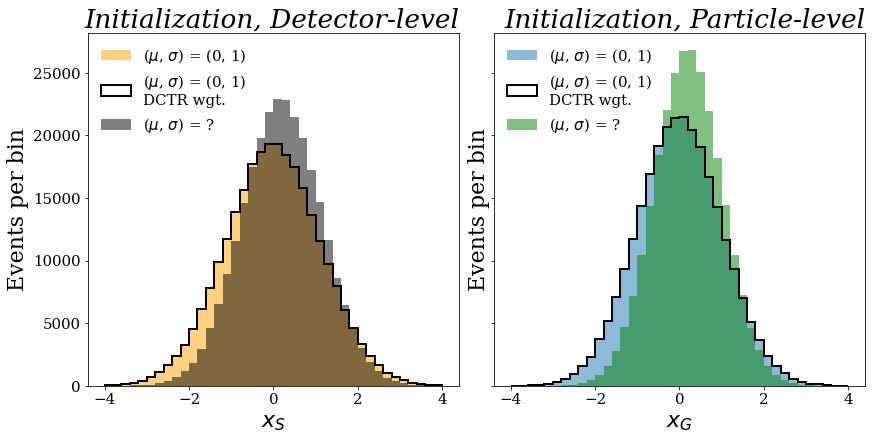

<Figure size 864x360 with 0 Axes>

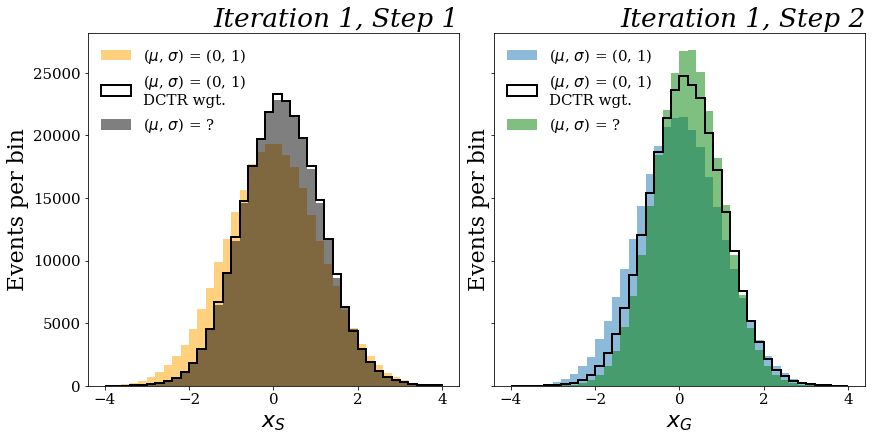

<Figure size 864x360 with 0 Axes>

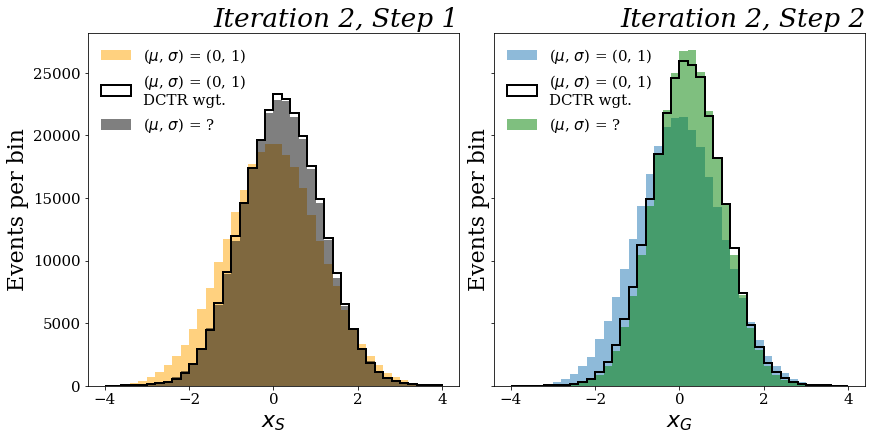

<Figure size 864x360 with 0 Axes>

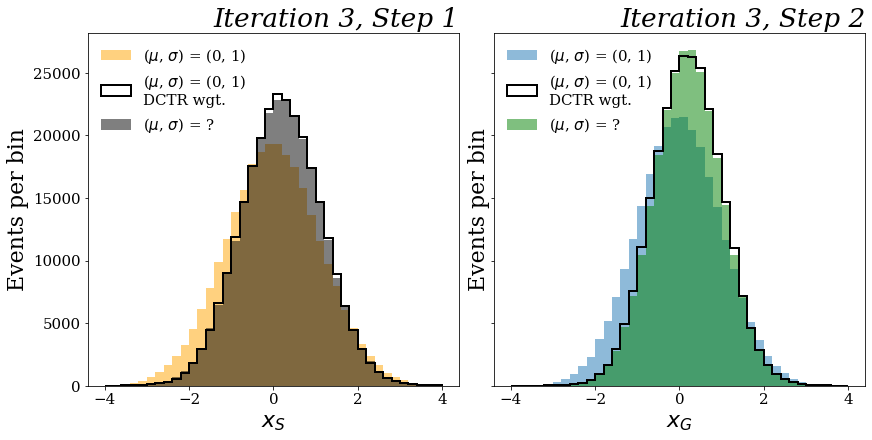

<Figure size 864x360 with 0 Axes>

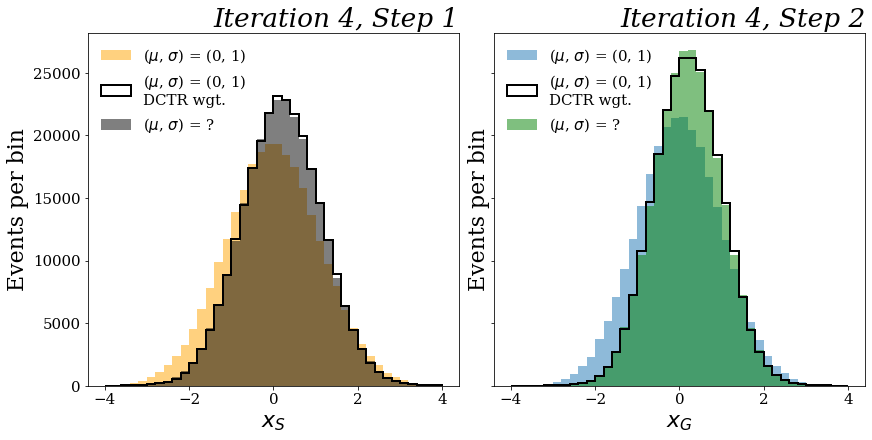

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.22799432, 0.81549996, 1.22912896, ..., 1.27428162,
         0.99575233, 1.0908215 ],
        [1.20765793, 1.0059253 , 1.20152199, ..., 1.20903373,
         1.05437279, 1.17502916]],

       [[1.29088724, 0.96014756, 1.28720069, ..., 1.31145215,
         1.04596353, 1.21378267],
        [1.29765987, 1.00505316, 1.28778601, ..., 1.28895462,
         1.08384013, 1.24842548]],

       [[1.30194271, 0.99864769, 1.29597592, ..., 1.32198775,
         1.08292174, 1.27630424],
        [1.33761644, 1.02313578, 1.32353711, ..., 1.31374288,
         1.10419738, 1.27921855]],

       [[1.31881976, 1.01187372, 1.30841494, ..., 1.32156932,
         1.07767713, 1.26135898],
        [1.3252362 , 1.01184928, 1.32016575, ..., 1.3107363 ,
         1.09665012, 1.27345133]]])

In [53]:
weights.shape

(4, 2, 300000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([-4.41105634, -8.77827266,  4.89949612, ...,  3.83863756,
       -1.46599204,  3.17784419])

In [57]:
x_data_and_MCback.shape

(720198,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(720198,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(720198,)

In [62]:
w_data

array([0.6939759 , 0.93771   , 0.93930835, ..., 0.06764219, 0.768709  ,
       0.17171149], dtype=float32)

In [63]:
w_data.shape

(330099,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([-1.66429704, -0.03739337, -0.00489997, ...,  3.83863756,
       -1.46599204,  3.17784419])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(330099,)

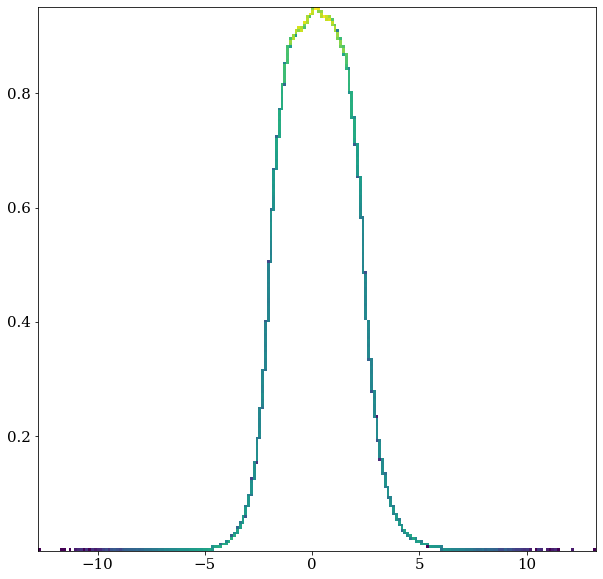

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

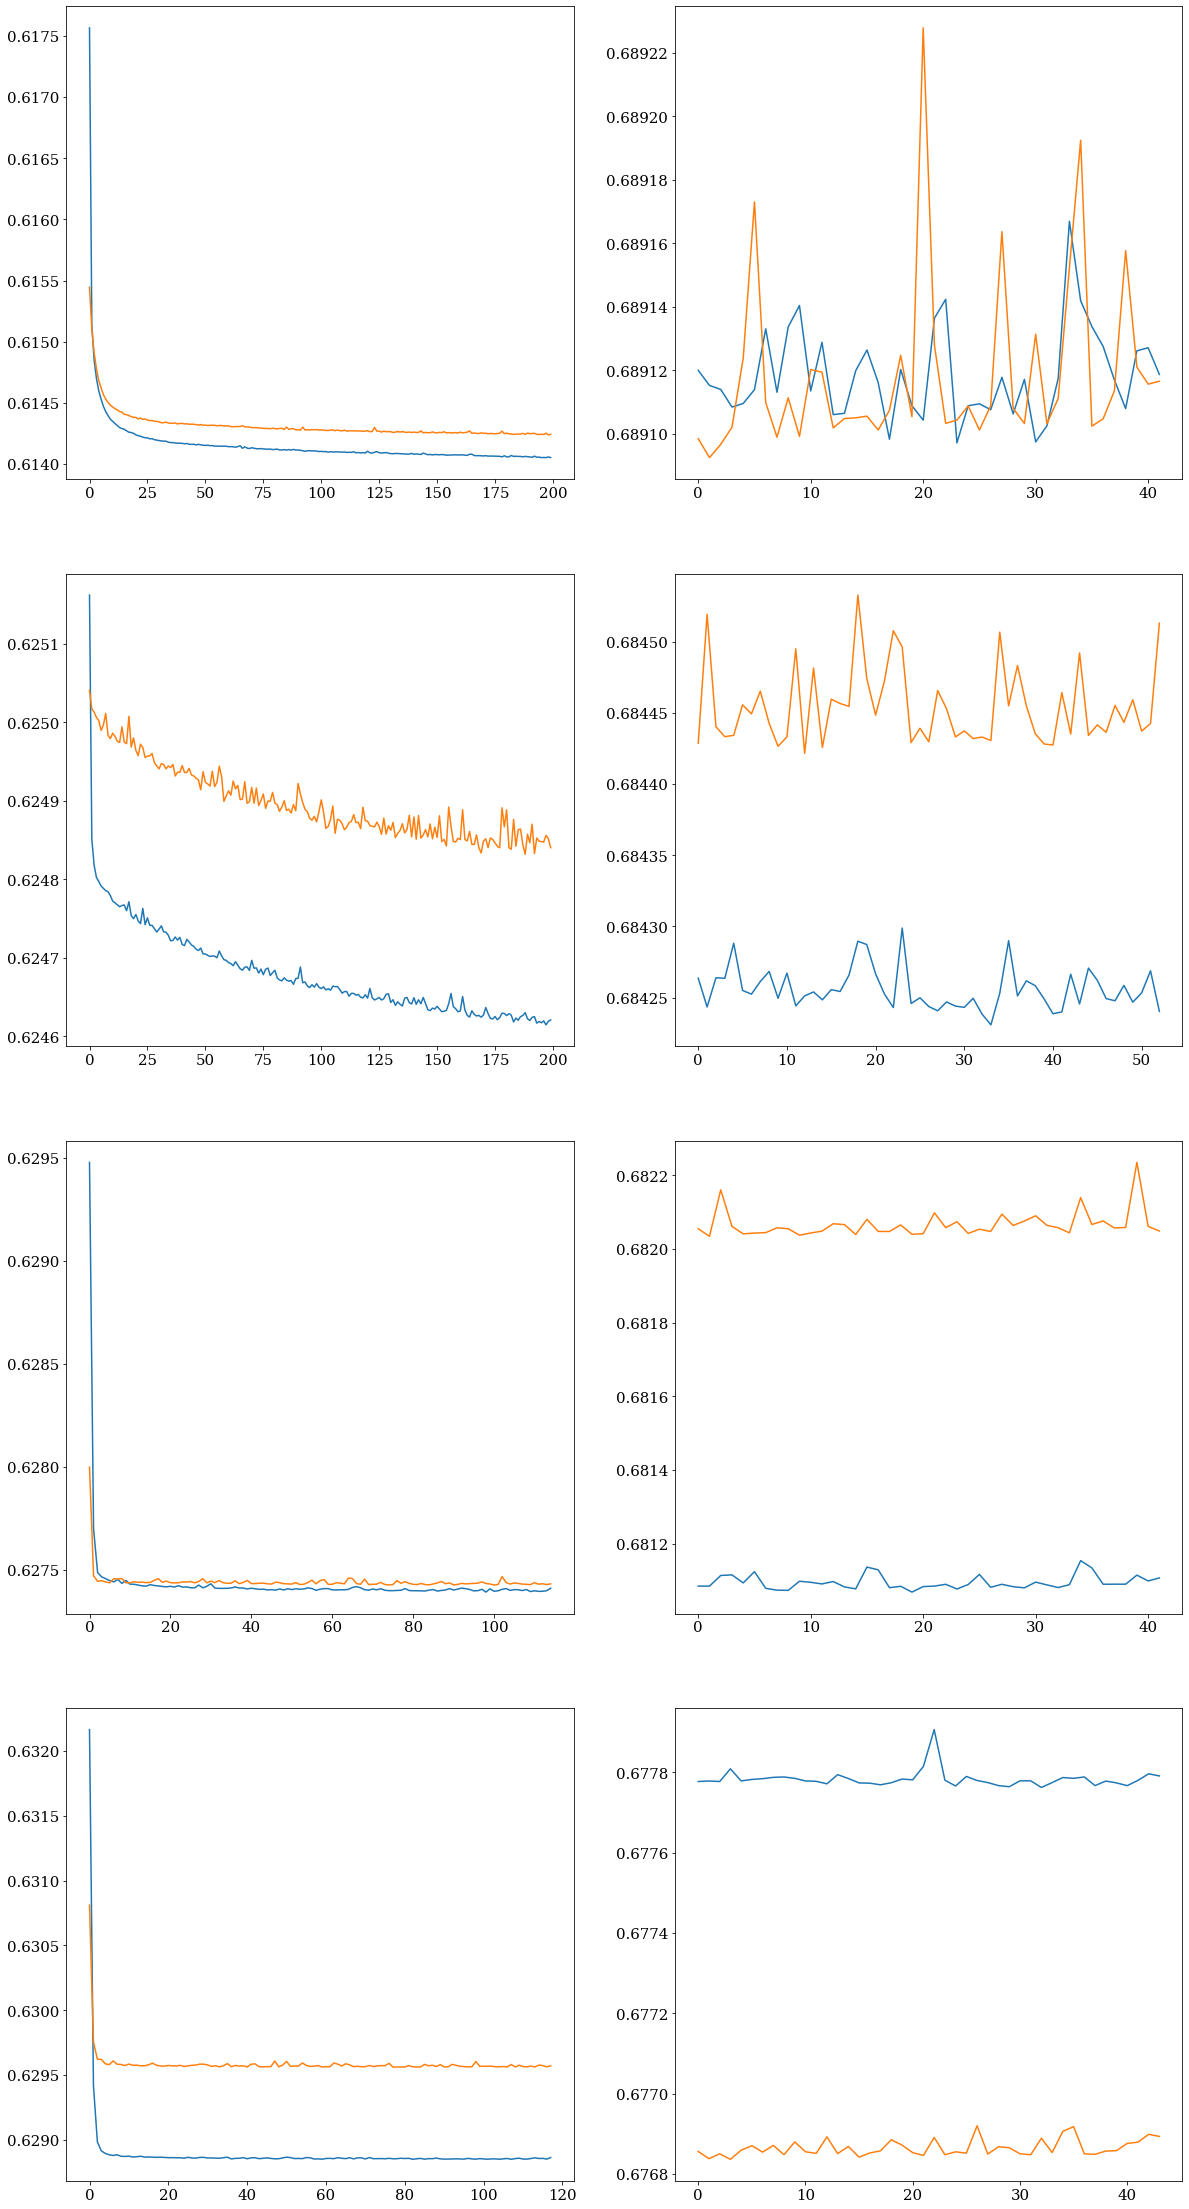

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()

## distributions of weights

### Weights on full simulation to match data (step1)

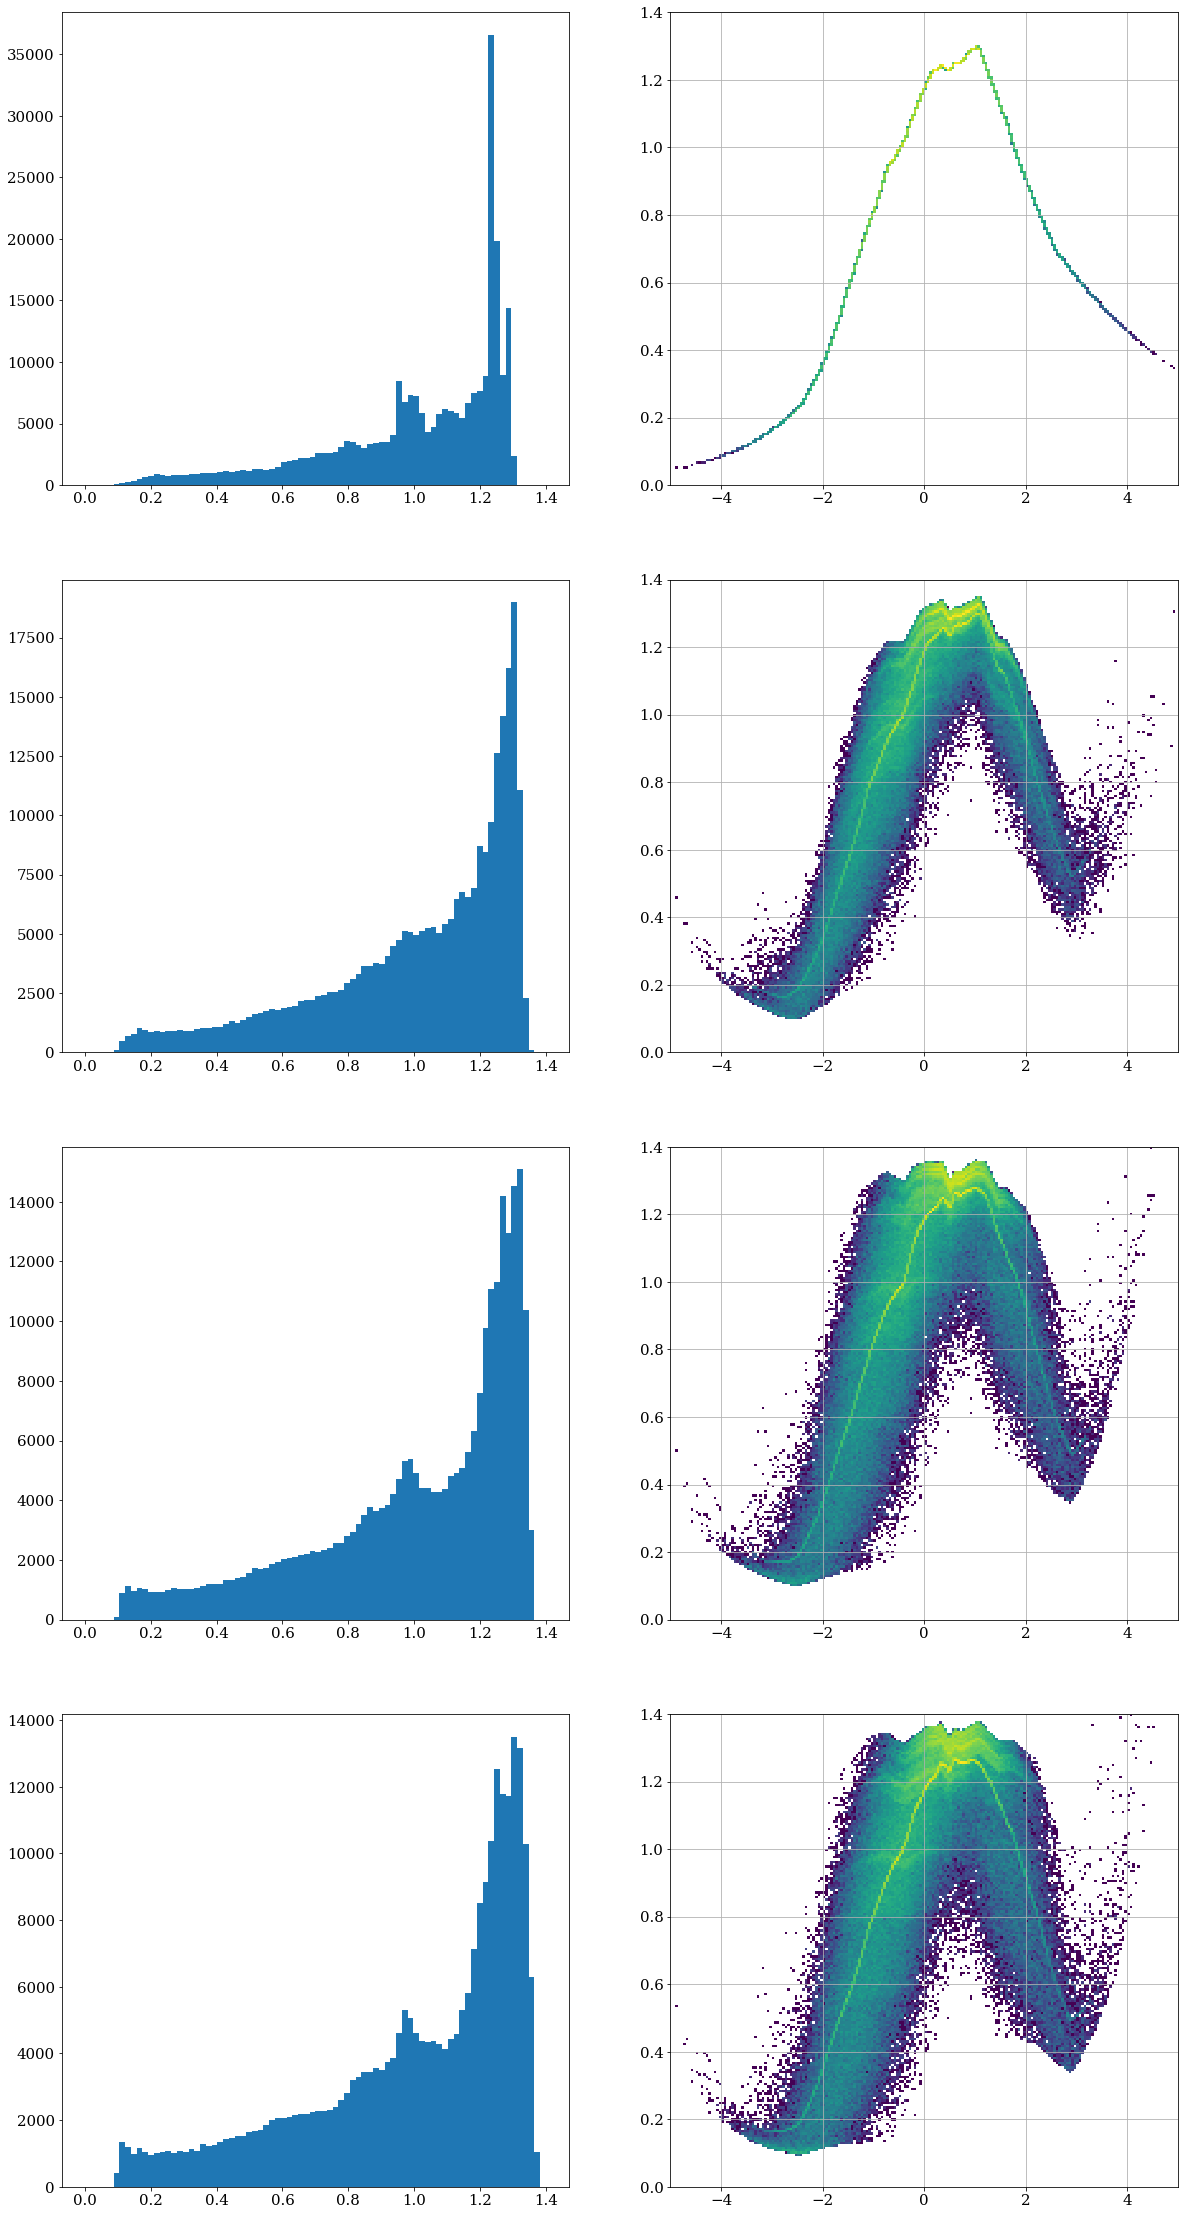

In [68]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,theta0_S!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

### Weights on gen (step2)

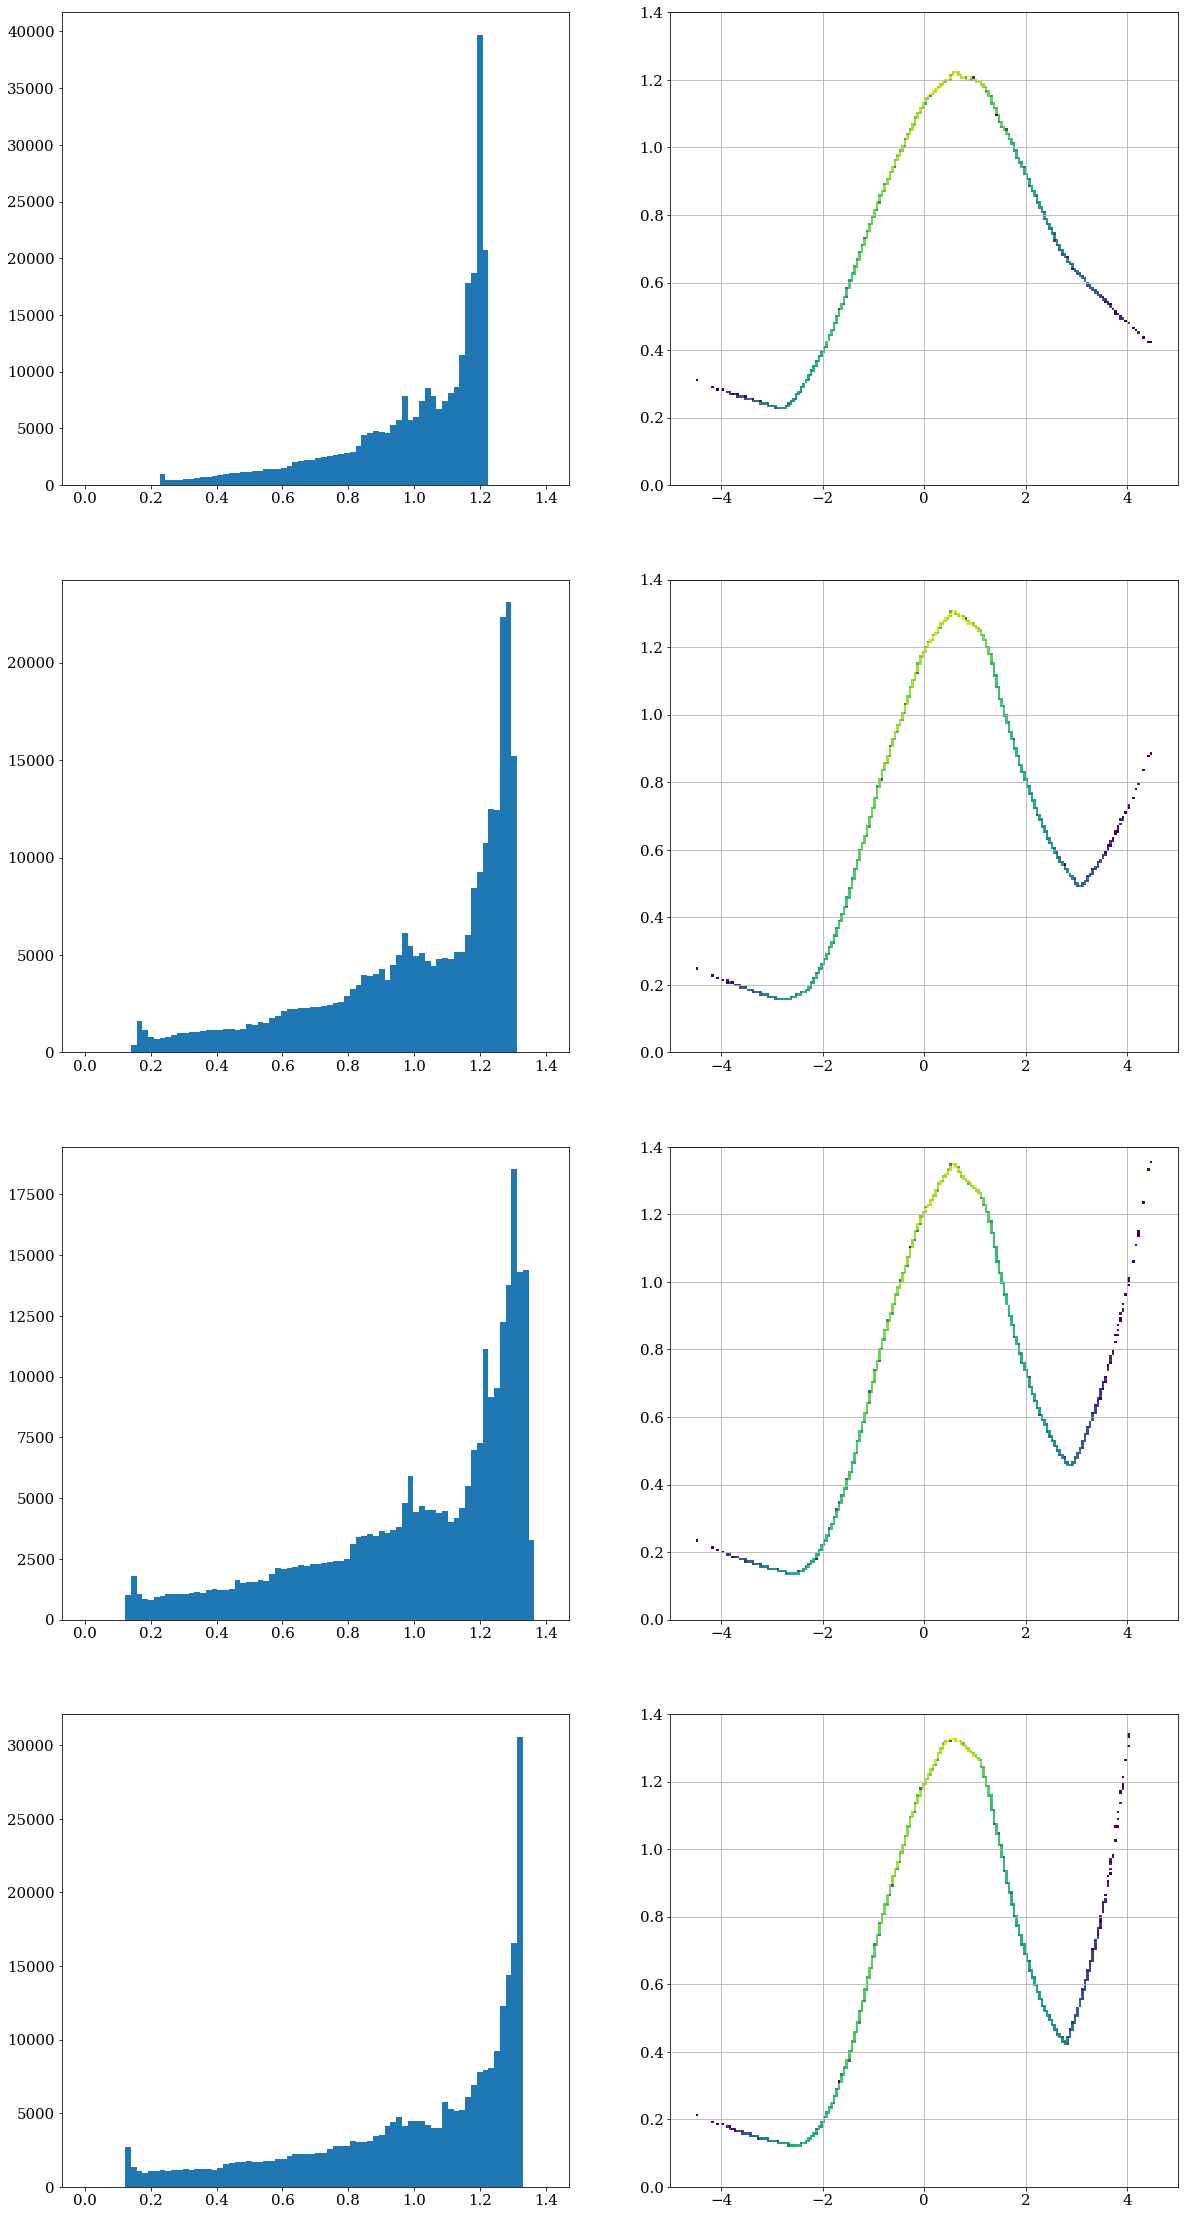

In [69]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,1,theta0_G!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on fullsim (step1) between consecutive iterations

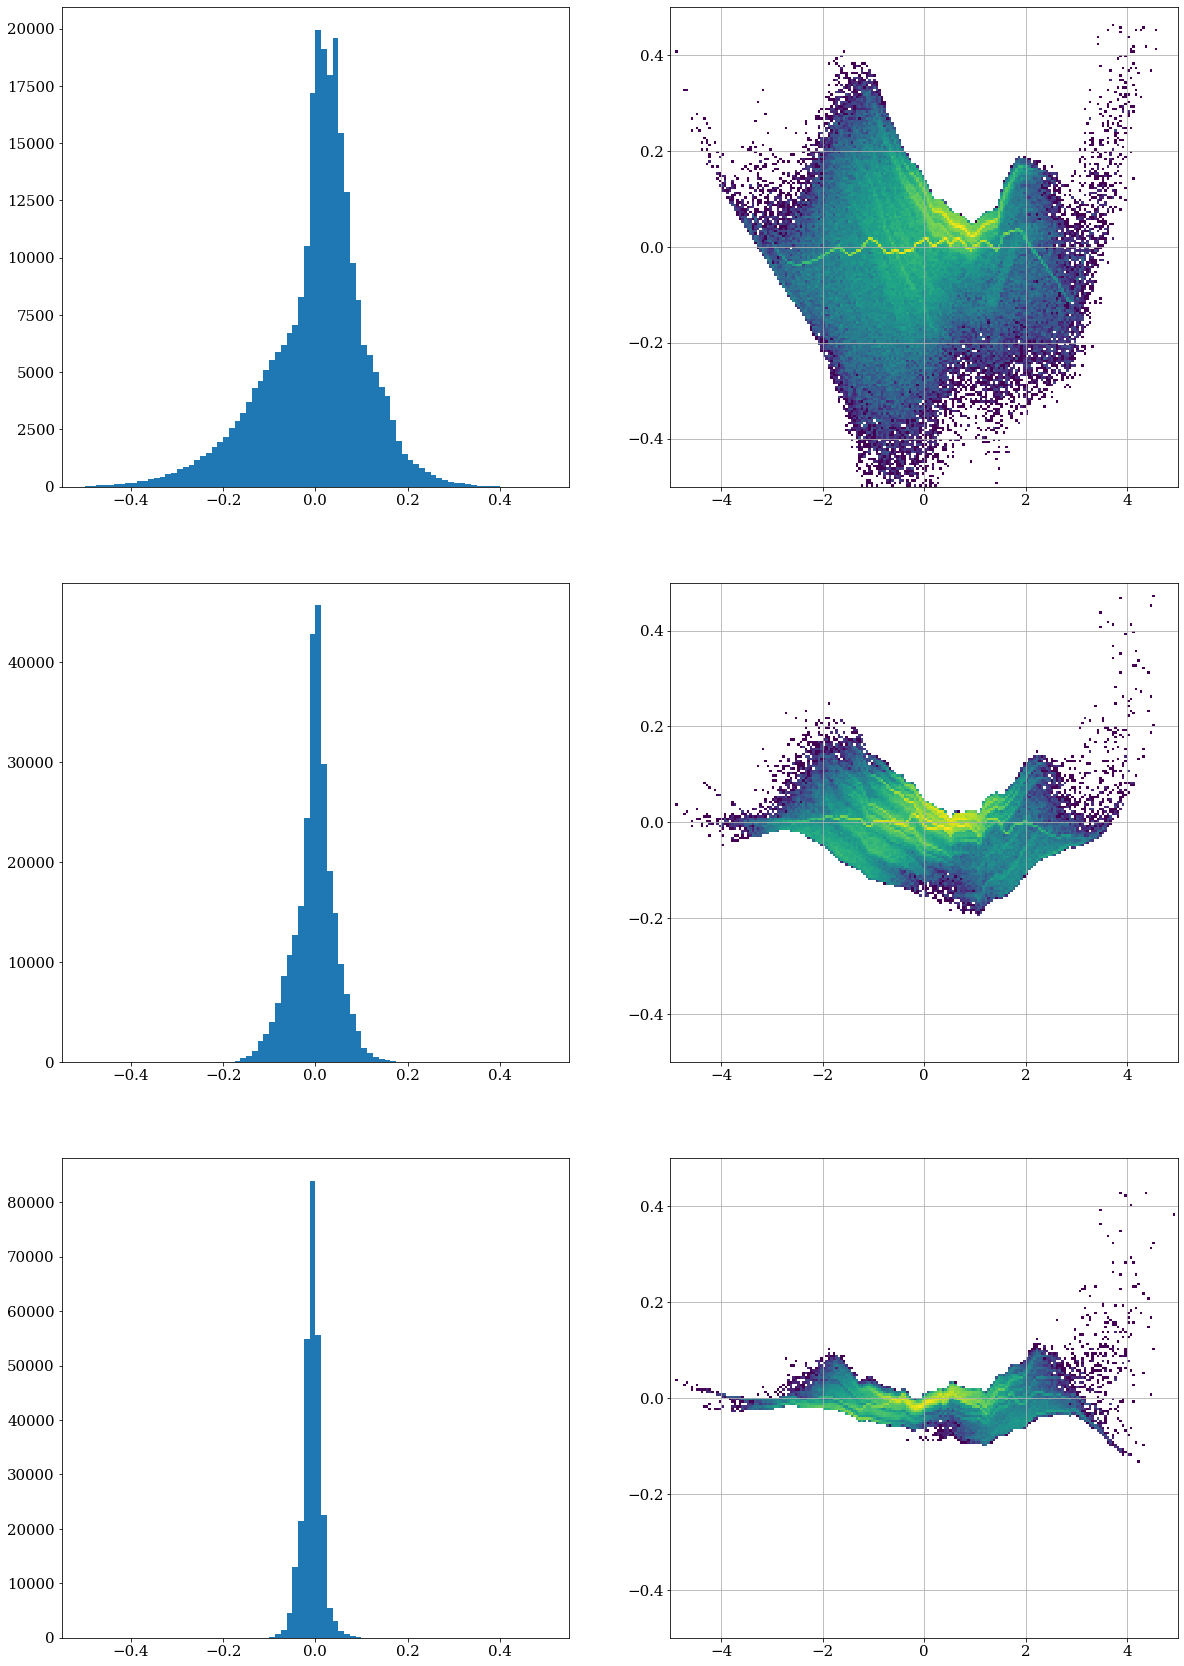

In [70]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], bins=80,
                 range=[-0.5,0.5])
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.5,0.5]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on gen (step2) between consecutive iterations

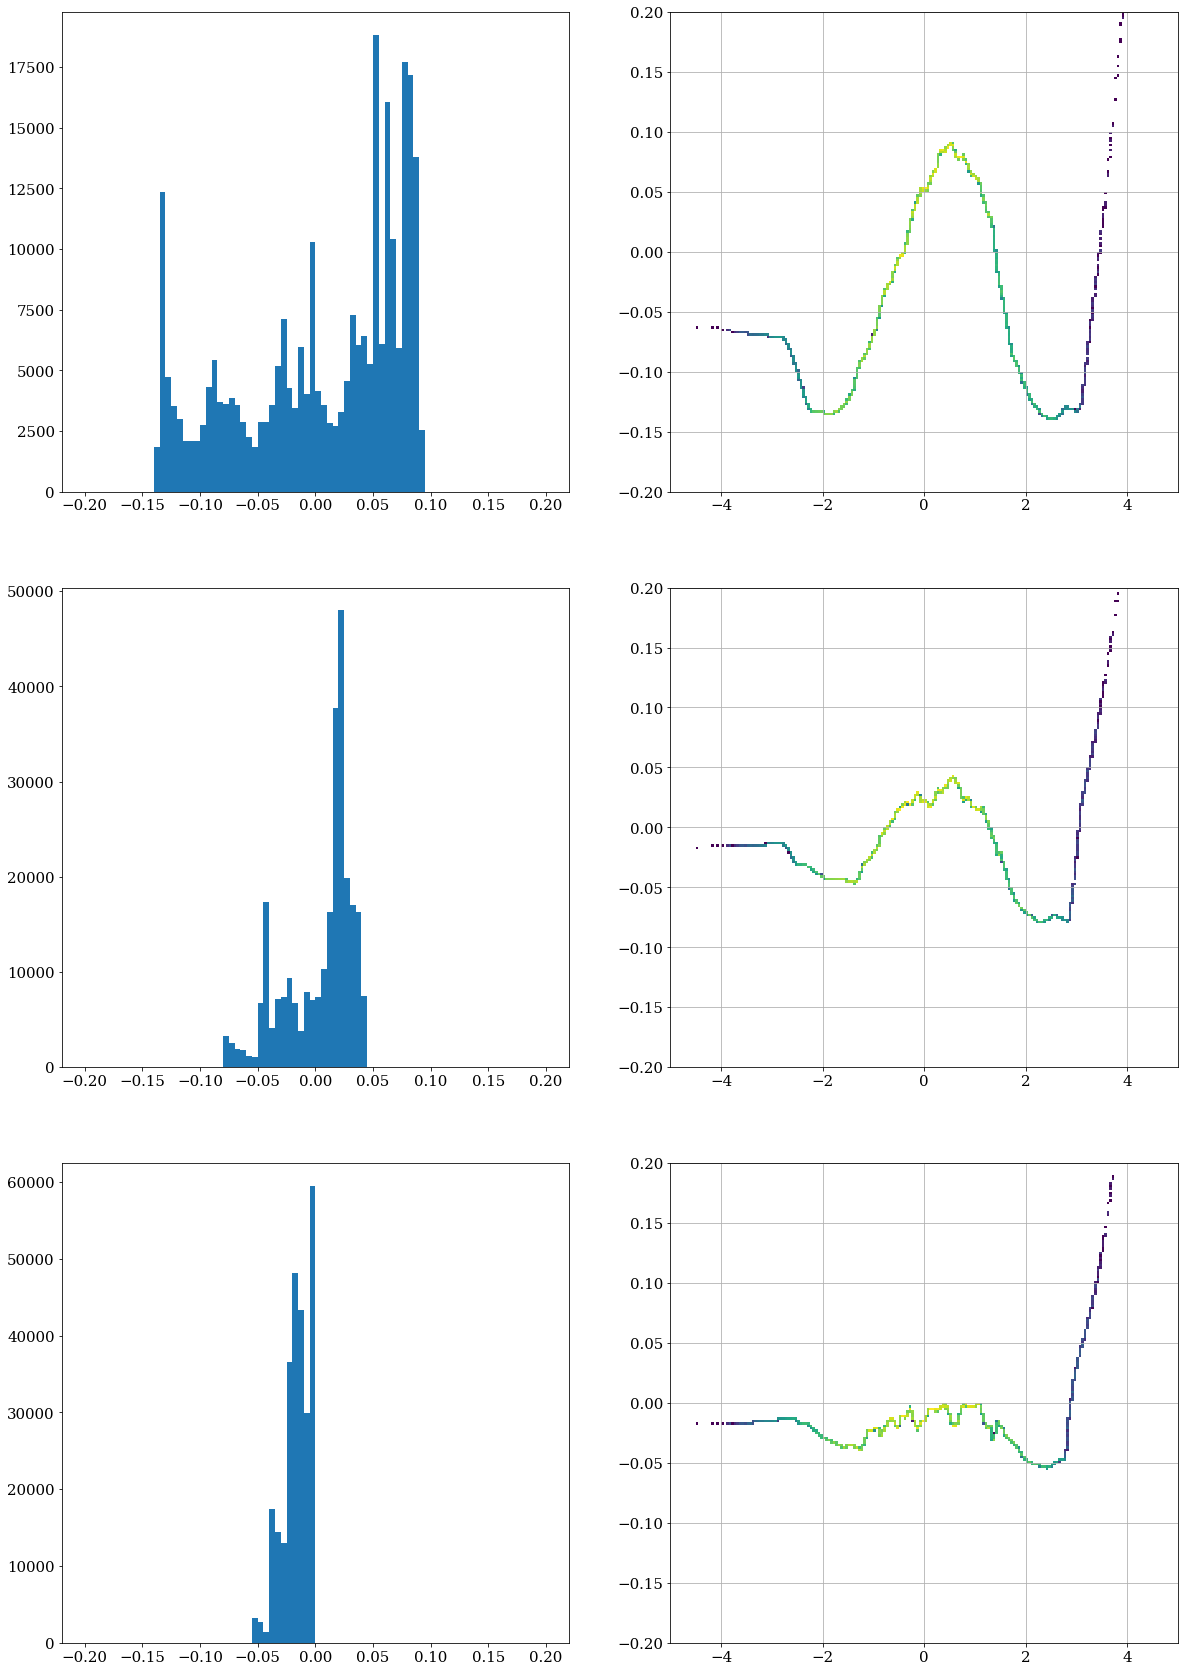

In [71]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], bins=80,
                 range=[-0.2,0.2])
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.2,0.2]))
    ax[i][1].grid()
    
plt.show()

In [72]:
nn_output

array([[[0.55116582, 0.44918755, 0.55139428, ..., 0.56030071,
         0.49893582, 0.5217191 ],
        [0.54703128, 0.50147694, 0.5457688 , ..., 0.54731339,
         0.51323342, 0.54023606]],

       [[0.51665556, 0.48835808, 0.5172134 , ..., 0.5203172 ,
         0.49799812, 0.50811148],
        [0.56477457, 0.5012601 , 0.56289619, ..., 0.56311935,
         0.52011675, 0.55524433]],

       [[0.50082374, 0.49840158, 0.50158489, ..., 0.5063259 ,
         0.49978808, 0.50552112],
        [0.57221383, 0.50571781, 0.56962168, ..., 0.56779987,
         0.52475941, 0.56125313]],

       [[0.49646205, 0.49723294, 0.49712721, ..., 0.50148493,
         0.49392262, 0.49648514],
        [0.56993616, 0.50294489, 0.56899631, ..., 0.5672375 ,
         0.5230487 , 0.56014013]]])

## Output of NN for step1: distinguish data from fullsim

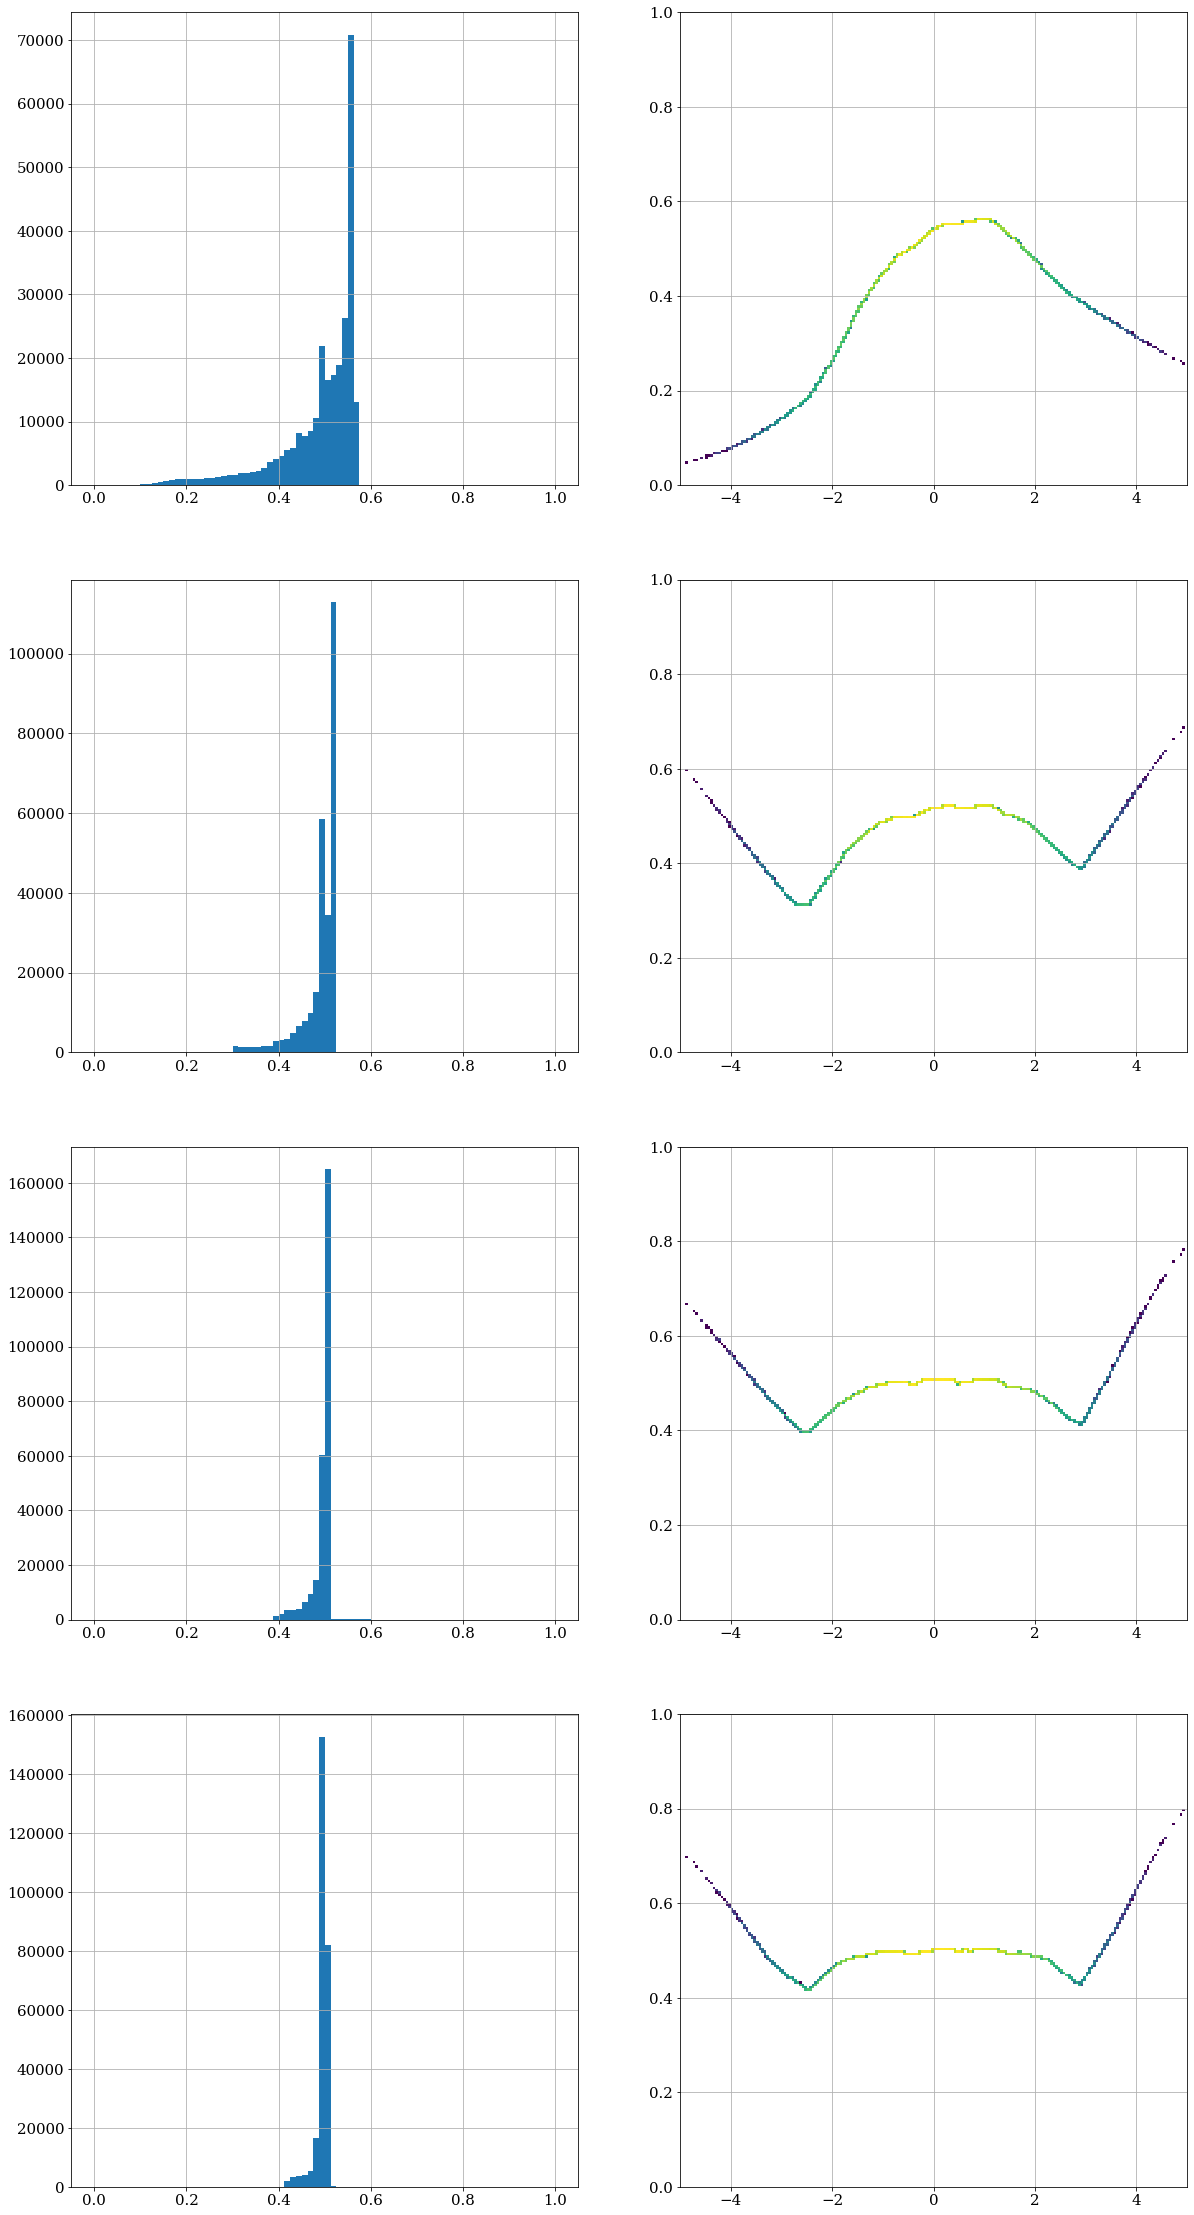

In [73]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,0,theta0_S!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## NN output of step2 : distinguish gen

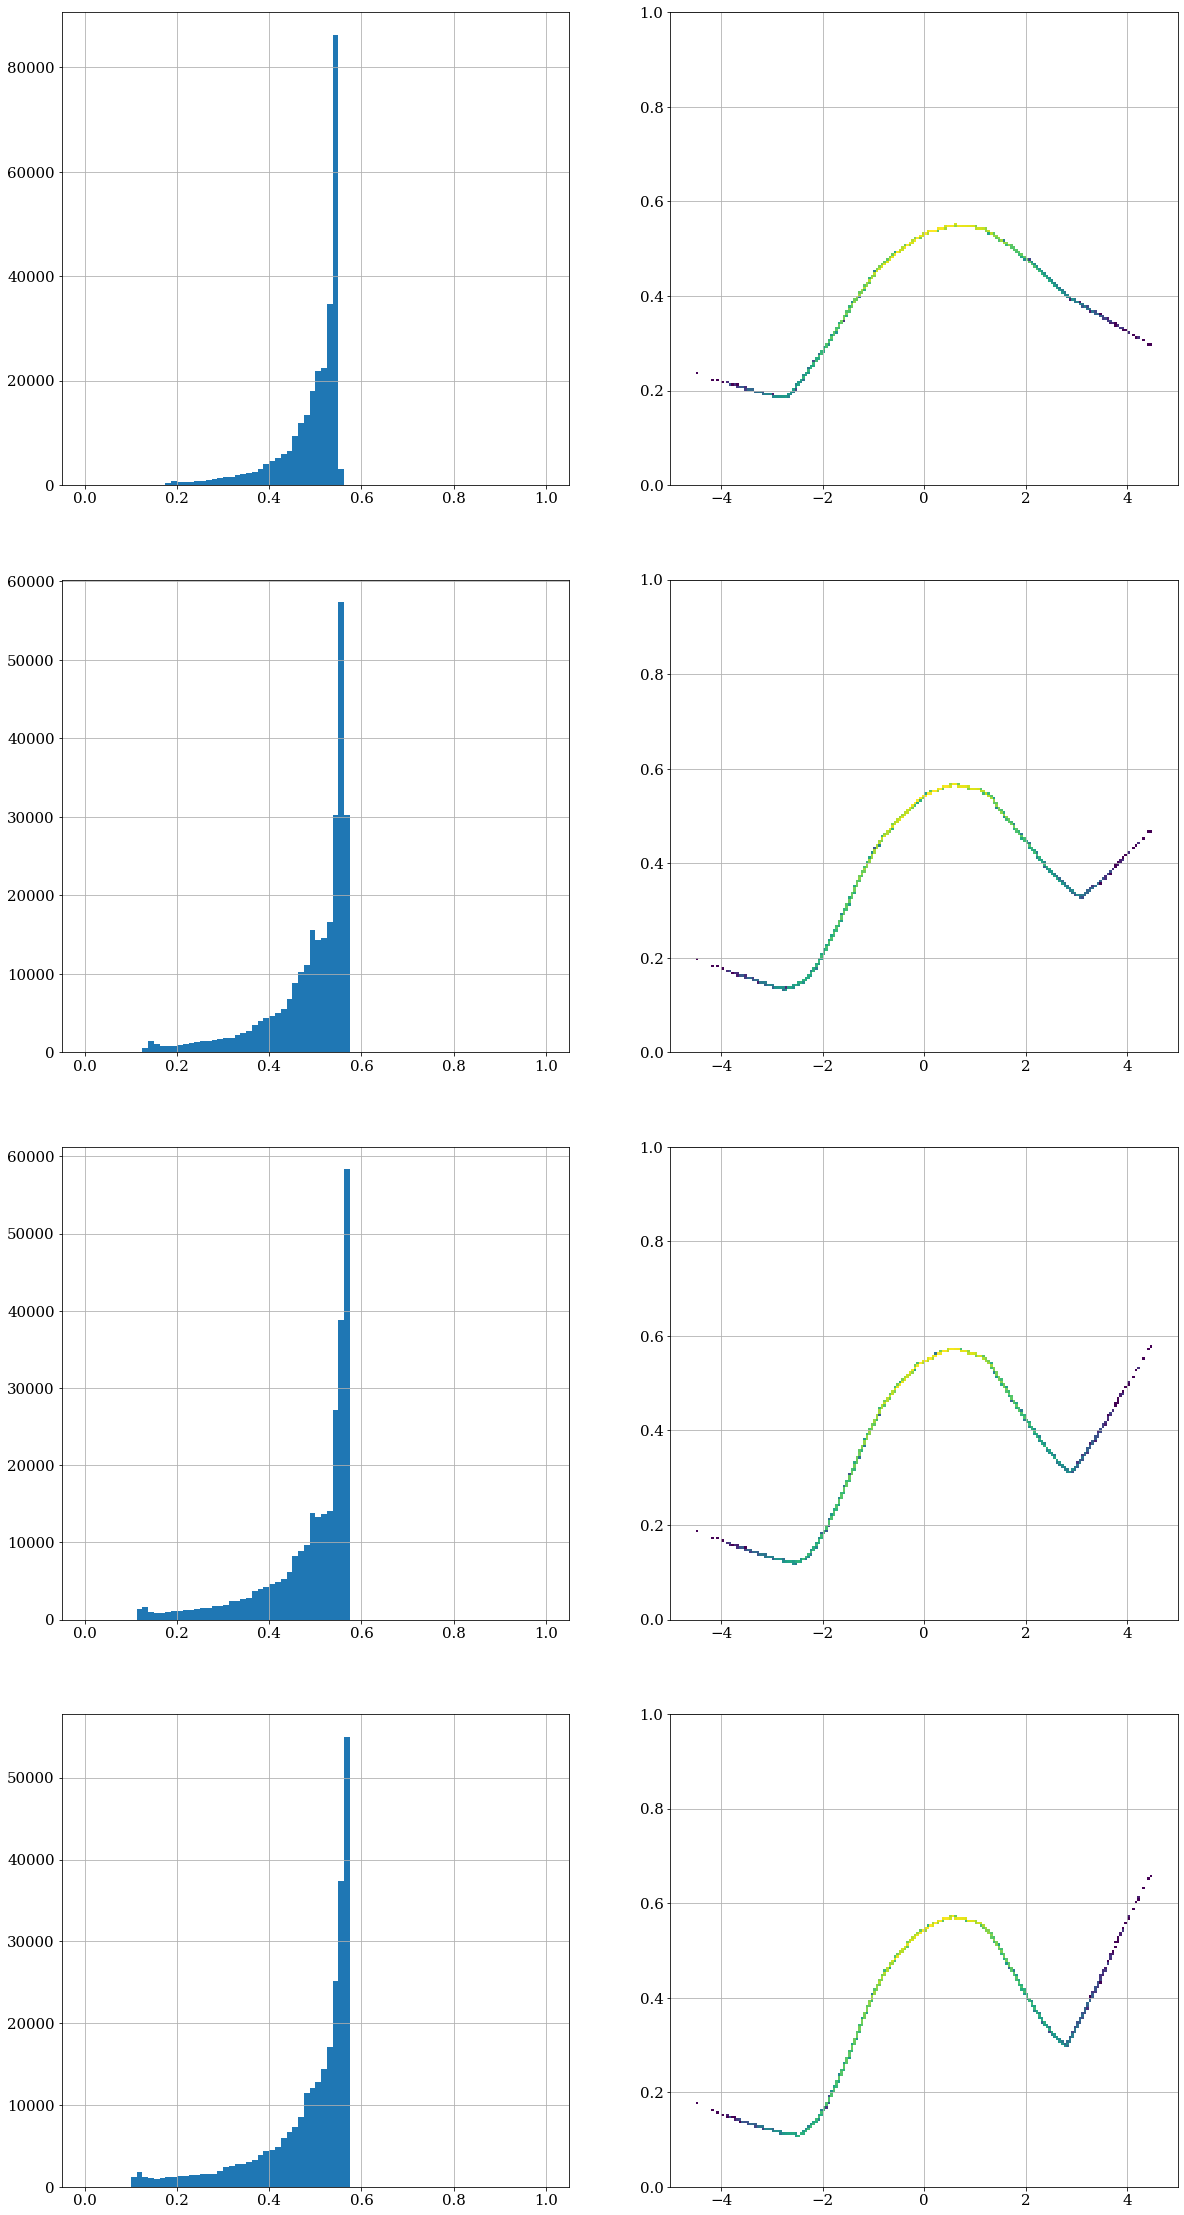

In [74]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,1,theta0_G!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()